<a href="https://colab.research.google.com/github/fehnicchio/IA/blob/main/Ex06_197003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nome: Fernando Henrique Velame Nicchio

RA: 197003

Curso: Eng. De Computação



# Ex06 - Desafio de classificação: detecção de tumores no cérebro

O objetivo deste desafio é classificar um conjunto de imagens 2D de cérebros saudáveis e cérebros contendo tumores. As imagens estão no diretório **Dados/Ex06/Brain_Tumor_Dataset**, subdivididas em conjuntos de treino, validação e teste. Note que as labels do conjunto de teste não estão disponíveis!

Sinta-se livre para utilizar qualquer classificador/técnica que desejar, mas lembre-se de justificar suas escolhas! A ideia é que você tente utilizar tudo que foi aprendido até aqui para obter um classificador com o melhor desempenho possível. Após definir o seu modelo final, você deve obter as predições para o conjunto de teste. Assim, além deste notebook com seus experimentos e comentários, você deve enviar também um arquivo com as suas predições para o conjunto de teste. Nas instruções do exercício no classroom você vai encontrar informações mais específicas sobre como enviar suas predições para o conjunto de teste.

**ATENÇÃO**: a nota deste exercício não vai se basear no desempenho final do seu classificador! Mais detalhes sobre os critérios de avaliação serão postados no classroom em breve.

Sugestões:
- Aplique técnicas de data augmentation;
- Tente utilizar modelos pré-treinados e técnicas de transfer learning;
- Tente modificar os hiperparâmetros (Optimizer, Learning-Rate, Número de Épocas, Tamanho do Batch, etc) para obter modelos com melhor desempenho;
- Utilize alguma ferramenta para acompanhamento e visualização das curvas de treino e validação (loss e acurácia). Por ex.: [Neptune](https://neptune.ai) ou [Wandb](https://wandb.ai/). Compare as diferentes versões de modelos utilizadas.

In [ ]:
# Instalando bibliotecas no Colab
!pip install pytorch-lightning torchinfo torchmetrics --quiet
!pip install efficientnet_pytorch
!pip install neptune-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=939d42d01a4aa9fc15313ac8d17ea445486e321b4795eee31135d0e53bf4696a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.1/502.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from efficientnet_pytorch import EfficientNet
import multiprocessing as mp
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter


pasta_compartilhada = "G_EA979A_2024S1"

In [9]:
# Conexão do colab com o drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
# Diretório contendo os dados
data_dir = f"gdrive/MyDrive/{pasta_compartilhada}/Dados/Ex06/Brain_Tumor_Dataset"

# Definir transformações para pré-processamento e data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Carregar os conjuntos de treinamento, validação e teste
train_data = ImageFolder(f"gdrive/MyDrive/{pasta_compartilhada}/Dados/Ex06/Brain_Tumor_Dataset/train", transform=train_transform)
val_data = ImageFolder(f"gdrive/MyDrive/{pasta_compartilhada}/Dados/Ex06/Brain_Tumor_Dataset/val", transform=val_transform)
test_data = ImageFolder(f"gdrive/MyDrive/{pasta_compartilhada}/Dados/Ex06/Brain_Tumor_Dataset/test", transform=val_transform)

# Dividir o conjunto de treinamento em treinamento e validação
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

# Definir DataLoader para os conjuntos de treinamento, validação e teste
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


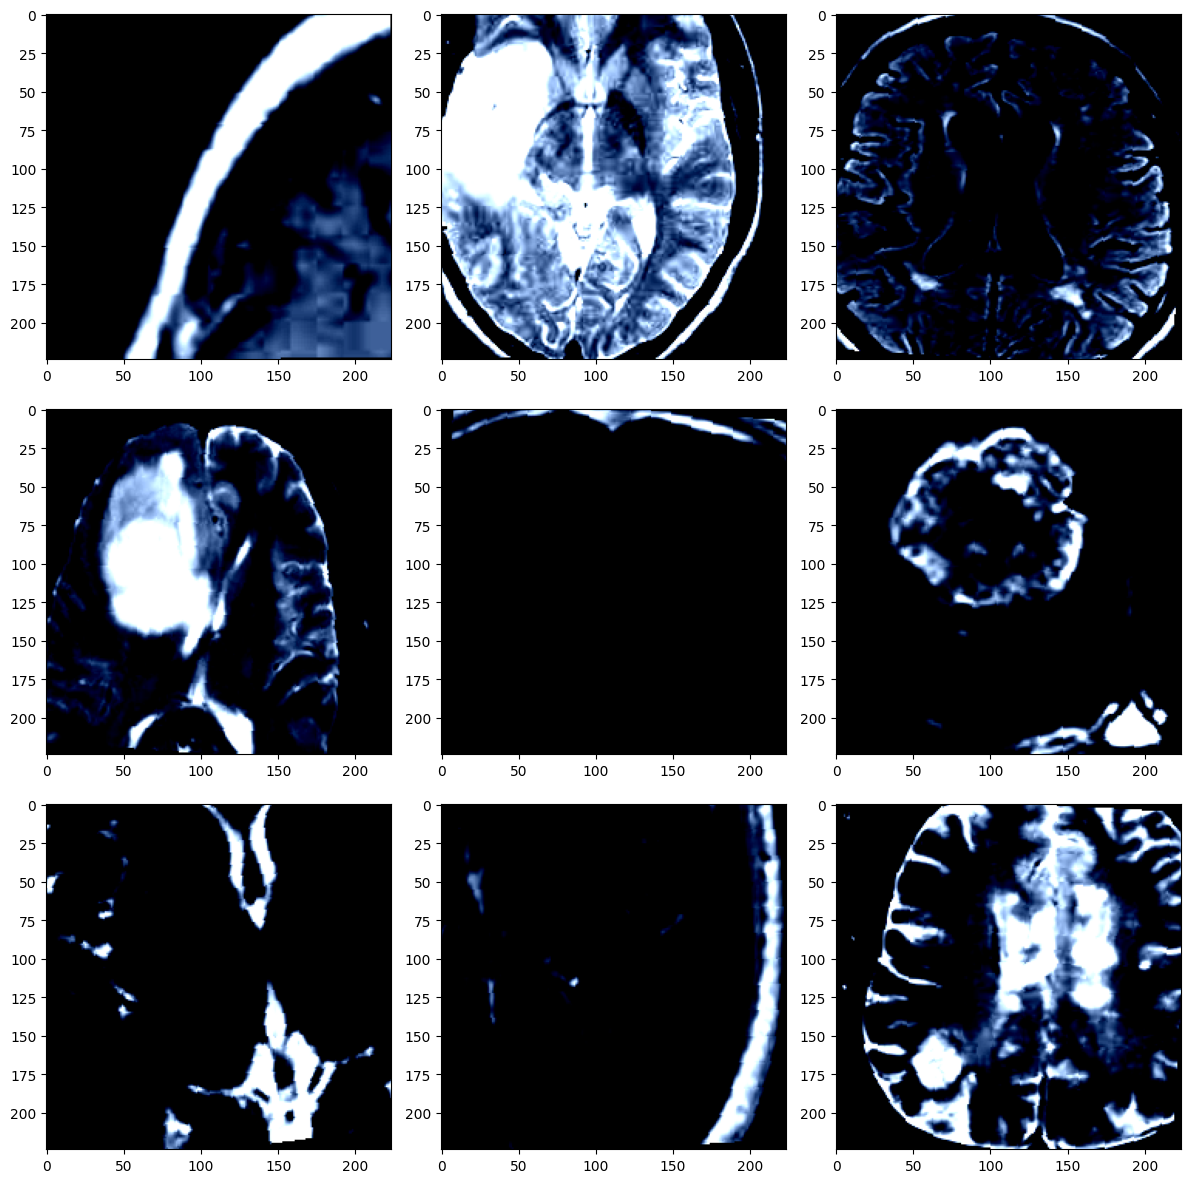

In [13]:
# Visualização de algumas imagens de treino com aumento de dados
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    for X_batch, y_batch in train_loader:
        image = X_batch[0].numpy().transpose((1, 2, 0))  # Convertendo para o formato (altura, largura, canais)
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [24]:
# Definir o modelo EfficientNet com ajuste de hiperparâmetros
class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomEfficientNet, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
        in_features = self.efficientnet._fc.in_features
        self.efficientnet._fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.efficientnet(x)

# Função para calcular a acurácia
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Função para treinar o modelo EfficientNet com hiperparâmetros ajustáveis
def train_efficientnet(train_loader, val_loader, hparams, log_dir):
    # Criar uma instância do modelo
    model = CustomEfficientNet(num_classes=hparams["nout"])

    # Definir a função de perda e o otimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=hparams["lr"], weight_decay=hparams["wd"])

    # Definir dispositivo de treinamento
    device = torch.device("cuda" if torch.cuda.is_available() and not hparams["cpu"] else "cpu")
    model.to(device)

    # Inicializar SummaryWriter para o TensorBoard
    writer = SummaryWriter(log_dir=log_dir)

    # Treinamento do modelo
    for epoch in range(hparams["max_epochs"]):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        train_loss = 0.0
        train_corrects = 0
        with torch.no_grad():
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                train_loss += criterion(outputs, labels).item() * images.size(0)
                train_corrects += torch.sum(preds == labels.data)
        train_loss /= len(train_loader.dataset)
        train_acc = train_corrects.double() / len(train_loader.dataset)

        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_loss += criterion(outputs, labels).item() * images.size(0)
                val_corrects += torch.sum(preds == labels.data)
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        # Log dos valores da perda e da acurácia no TensorBoard
        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_acc, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)

        print(f'Epoch {epoch + 1}/{hparams["max_epochs"]}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Treinamento do modelo
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    writer.close()
    return model

# Define os hiperparâmetros
hparams = {
    "experiment_name": "EfficientNet",
    "max_epochs": 10,
    "batch_size": 32,
    "nworkers": mp.cpu_count(),
    "nout": 2,
    "lr": 1e-4,
    "wd": 1e-5,
    "cpu": False
}

# Define o diretório de log para o TensorBoard
log_dir = "gdrive/MyDrive/tensorboard_logs"

# Treina o modelo EfficientNet com os hiperparâmetros especificados
model = train_efficientnet(train_loader, val_loader, hparams, log_dir)

print('Finished Training')

# Avaliar o modelo no conjunto de teste
test_acc = 0.0
model.eval()
# Definir dispositivo de treinamento
device = torch.device("cuda" if torch.cuda.is_available() and not hparams["cpu"] else "cpu")
model.to(device)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_acc += accuracy(outputs, labels) * images.size(0)
test_acc /= len(test_loader.dataset)
print(f'Test Accuracy: {test_acc:.4f}')

Loaded pretrained weights for efficientnet-b0
Epoch 1/10, Train Loss: 0.7088, Train Acc: 0.4211, Val Loss: 0.7012, Val Acc: 0.4138
Epoch 2/10, Train Loss: 0.5561, Train Acc: 0.6754, Val Loss: 0.5311, Val Acc: 0.7241
Epoch 3/10, Train Loss: 0.6283, Train Acc: 0.5877, Val Loss: 0.6946, Val Acc: 0.6552
Epoch 4/10, Train Loss: 0.7234, Train Acc: 0.6404, Val Loss: 0.7826, Val Acc: 0.6552
Epoch 5/10, Train Loss: 0.3838, Train Acc: 0.8860, Val Loss: 0.3870, Val Acc: 0.8621
Epoch 6/10, Train Loss: 0.3441, Train Acc: 0.8772, Val Loss: 0.2967, Val Acc: 0.8966
Epoch 7/10, Train Loss: 0.3522, Train Acc: 0.8246, Val Loss: 0.2585, Val Acc: 0.9310
Epoch 8/10, Train Loss: 0.2959, Train Acc: 0.8860, Val Loss: 0.2348, Val Acc: 0.8966
Epoch 9/10, Train Loss: 0.2459, Train Acc: 0.8860, Val Loss: 0.2083, Val Acc: 0.8966
Epoch 10/10, Train Loss: 0.1512, Train Acc: 0.9474, Val Loss: 0.2762, Val Acc: 0.9310
Finished Training
Test Accuracy: 0.6042


In [31]:
# Gerar previsões para o conjunto de teste
predictions = []
model.eval()
# Definir dispositivo de treinamento
device = torch.device("cuda" if torch.cuda.is_available() and not hparams["cpu"] else "cpu")
model.to(device)
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())

# Salvar as previsões em um arquivo de texto
with open(f'gdrive/MyDrive/predictions.txt', 'w') as f:
    for pred in predictions:
        f.write(str(pred) + '\n')

print('Predictions saved to predictions.txt')

Predictions saved to predictions.txt


In [33]:
#Iniciar o TensorBoard, usar o seguinte comando no terminal do Colab
# tensorboard --logdir=f'gdrive/MyDrive/tensorboard_logs